# Fire Weather Prediction within Oregon and Washington: Regional

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

%matplotlib notebook

In [216]:
# Improvements to make:
# 1) Allow for specifying which NARR variables to use for model training
# 2) Use those NARR variable names in the naming of saved figures e.g. H500 instead of H500_0, H500_1, H500_2 as
#    this results in an enormous file name.

## Importing multi-location NARR-gridMET data

In [218]:
df_narr_erc = pd.read_csv('/home/dp/Documents/FWP/NARR_gridMET/csv/Training/df_NARR_gridMET_Random_reg_all_years.csv', header='infer')
display('df_narr_erc head:', df_narr_erc.head(5))
display('df_narr_erc tail:', df_narr_erc.tail(5))

# This csv contains the mapping between the feature suffixes (0, 1, etc) and
# the locations' lat-lon coordinates. Useful for plotting purposes.
df_loc = pd.read_csv('/home/dp/Documents/FWP/NARR_gridMET/csv/Training/df_NARR_gridMET_Random_reg_key.csv', header='infer', )
display('df_loc:', df_loc)

'df_narr_erc head:'

time      H500_0      H500_1      H500_2      H500_3      H500_4  \
0  1979-01-02  5715.97000  5716.30625  5716.40375  5716.37250  5716.21250   
1  1979-01-03  5650.36625  5652.44000  5654.18625  5655.81750  5657.34000   
2  1979-01-04  5596.66250  5599.31000  5601.76000  5604.09875  5606.32875   
3  1979-01-05  5600.45250  5601.19125  5601.91500  5602.58375  5603.14500   
4  1979-01-06  5585.27625  5585.11500  5584.64250  5584.15250  5583.76125   

       H500_5      H500_6      H500_7      H500_8  ...  ERC_86  ERC_87  \
0  5715.78500  5715.22125  5714.44875  5712.90000  ...    20.0    19.0   
1  5658.73125  5659.97375  5660.94875  5649.19000  ...    23.0    22.0   
2  5608.41750  5610.26000  5611.76875  5596.05375  ...    12.0    11.0   
3  5603.66625  5604.10125  5604.40500  5598.58000  ...    19.0    18.0   
4  5583.24250  5582.58625  5581.82375  5583.81500  ...    24.0    22.0   

   ERC_88  ERC_89  ERC_90  ERC_91  ERC_92  ERC_93  ERC_94  ERC_95  
0    20.0    21.0    15.0    13.0    13.0    19.0    22.0    22.0  
1    12.0    14.0    16.0    14.0    14.0    21.0    24.0    24.0  
2     9.0    10.0     8.0     8.0     7.0    11.0    14.0    14.0  
3    15.0     9.0     8.0     9.0    14.0    18.0    23.0    20.0  
4    21.0    22.0    18.0    18.0    17.0    22.0    26.0    25.0  

[5 rows x 673 columns]

'df_narr_erc tail:'

time     H500_0      H500_1      H500_2      H500_3    H500_4  \
1816  1983-12-27  5508.1800  5505.67125  5503.75875  5501.95625  5500.240   
1817  1983-12-28  5619.3700  5616.32875  5613.10000  5609.72000  5606.225   
1818  1983-12-29  5695.6575  5695.65500  5695.57250  5695.43000  5695.315   
1819  1983-12-30  5641.4650  5644.72375  5648.45875  5652.25625  5656.040   
1820  1983-12-31  5610.7400  5611.30500  5611.99000  5612.82000  5613.785   

          H500_5      H500_6      H500_7      H500_8  ...  ERC_86  ERC_87  \
1816  5498.49250  5496.73000  5494.98750  5497.79500  ...     0.0     0.0   
1817  5602.61000  5599.04125  5595.51000  5615.08625  ...     0.0     0.0   
1818  5694.98125  5694.58375  5693.99750  5691.89125  ...     0.0     0.0   
1819  5659.09750  5661.97250  5664.69375  5636.11500  ...     0.0     0.0   
1820  5614.73500  5615.58000  5616.35000  5602.69500  ...     0.0     0.0   

      ERC_88  ERC_89  ERC_90  ERC_91  ERC_92  ERC_93  ERC_94  ERC_95  
1816     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1817     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1818     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1819    -0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1820     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 673 columns]

'df_loc:'

key                 loc
0     0  (42.0588, 236.059)
1     1  (42.0588, 236.314)
2     2  (42.0588, 236.569)
3     3  (42.0588, 236.824)
4     4  (42.0588, 237.078)
..  ...                 ...
91   91  (44.8627, 236.824)
92   92  (44.8627, 237.078)
93   93  (44.8627, 237.333)
94   94  (44.8627, 237.588)
95   95  (44.8627, 237.843)

[96 rows x 2 columns]

<IPython.core.display.Javascript object>


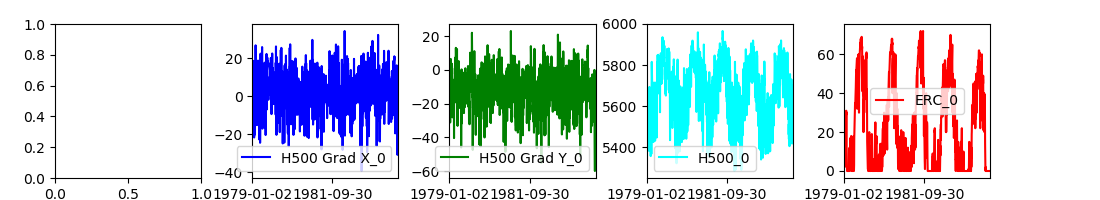

<IPython.core.display.Javascript object>


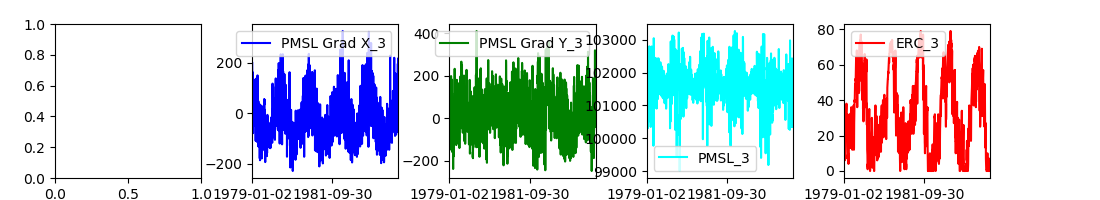

In [219]:
# Plotting ERC and H500 variables
fig1, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(11,2))
# df_narr_erc.plot(x='time', y='noise', ax=ax0, color='gray')
df_narr_erc.plot(x='time', y='H500 Grad X_0', ax=ax1, color='blue')
df_narr_erc.plot(x='time', y='H500 Grad Y_0', ax=ax2, color='green')
df_narr_erc.plot(x='time', y='H500_0', ax=ax3, color='cyan')
df_narr_erc.plot(x='time', y='ERC_0', ax=ax4, color='red')
plt.subplots_adjust(wspace=0.35, left=0.05)
plt.show()

# Plotting ERC and PMSL variables
fig2, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(11,2))
# df_narr_erc.plot(x='time', y='noise', ax=ax0, color='gray')
df_narr_erc.plot(x='time', y='PMSL Grad X_3', ax=ax1, color='blue')
df_narr_erc.plot(x='time', y='PMSL Grad Y_3', ax=ax2, color='green')
df_narr_erc.plot(x='time', y='PMSL_3', ax=ax3, color='cyan')
df_narr_erc.plot(x='time', y='ERC_3', ax=ax4, color='red')
plt.subplots_adjust(wspace=0.35, left=0.05)
plt.show()

In [220]:
# Specify columns to train on
cols_a = ['H500','PMSL','ERC'] # Good predictions: Test Score: 0.02 MSE (0.14 RMSE)
cols_b = ['H500','ERC'] # Good predictions: 0.02 MSE (0.15 RMSE)
cols_c = ['PMSL','ERC'] # Poor predictions, focused on the average ERC value of 30 - Test Score: 0.09 MSE (0.30 RMSE)
cols_d = ['H500 Grad X', 'H500 Grad Y','PMSL Grad X','PMSL Grad Y', 'ERC']
cols_e = ['H500 Grad X', 'H500 Grad Y', 'ERC']
cols_f = ['PMSL Grad X','PMSL Grad Y', 'ERC']
cols_g = ['PMSL Grad Y', 'H500 Grad Y', 'ERC']
cols_h = ['noise','ERC']
cols_i = ['ERC']
cols_j = ['noise']

# Currently using all columns except the first ('time') column:
cols = list(df_narr_erc.columns)[1:]

df = df_narr_erc.loc[:, cols]

display('df to train on:', df.head(5))
n_samples = df.shape[0]
n_features = df.shape[1]-1
n_locations = sum('ERC' in x for x in list(df.columns))
print('Number of samples:', n_samples)
print('Number of features:', n_features)
print('Number of locations in dataset:', n_locations)

'df to train on:'

H500_0      H500_1      H500_2      H500_3      H500_4      H500_5  \
0  5715.97000  5716.30625  5716.40375  5716.37250  5716.21250  5715.78500   
1  5650.36625  5652.44000  5654.18625  5655.81750  5657.34000  5658.73125   
2  5596.66250  5599.31000  5601.76000  5604.09875  5606.32875  5608.41750   
3  5600.45250  5601.19125  5601.91500  5602.58375  5603.14500  5603.66625   
4  5585.27625  5585.11500  5584.64250  5584.15250  5583.76125  5583.24250   

       H500_6      H500_7      H500_8      H500_9  ...  ERC_86  ERC_87  \
0  5715.22125  5714.44875  5712.90000  5713.21500  ...    20.0    19.0   
1  5659.97375  5660.94875  5649.19000  5651.05750  ...    23.0    22.0   
2  5610.26000  5611.76875  5596.05375  5598.58375  ...    12.0    11.0   
3  5604.10125  5604.40500  5598.58000  5599.30250  ...    19.0    18.0   
4  5582.58625  5581.82375  5583.81500  5583.45000  ...    24.0    22.0   

   ERC_88  ERC_89  ERC_90  ERC_91  ERC_92  ERC_93  ERC_94  ERC_95  
0    20.0    21.0    15.0    13.0    13.0    19.0    22.0    22.0  
1    12.0    14.0    16.0    14.0    14.0    21.0    24.0    24.0  
2     9.0    10.0     8.0     8.0     7.0    11.0    14.0    14.0  
3    15.0     9.0     8.0     9.0    14.0    18.0    23.0    20.0  
4    21.0    22.0    18.0    18.0    17.0    22.0    26.0    25.0  

[5 rows x 672 columns]

Number of samples: 1821
Number of features: 671
Number of locations in dataset: 96


## The following is set to calculate the last n_locations features as a result.

In [221]:
def load_data(df_fwp, seq_len):
    amount_of_features = len(df_fwp.columns)

    # We know that 'result' is the length of 'data' - 'sequence_length' (e.g. 1821 - 15 = 1806)
    # Cutting the train from test at round(0.9*1806) = 1625 + sequence_length = 1640 is all of the training data
    # This allows me to scale the training and testing data before splitting the data into batches:
    data = df_fwp.values
    print('data.shape:\n', data.shape)
    print('data[:3]:\n', data[:3])
    sequence_length = seq_len + 1

    train_test_row = round(0.9*(len(data)-sequence_length))
    print('train_test_row:\n', train_test_row)

    # Scaling:
#     scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    train_temp = data[:train_test_row,:]
    print('train_temp.shape:\n', train_temp.shape)
    print('train_temp[:10]:\n', train_temp)
    print(scaler.fit(train_temp))
    data = scaler.transform(data)
    print('Scaled data:\n', data[:10])
    print('Scaler coefs:\n', scaler.scale_)
    print('--------------------------------------------')

    # Plotting hist of scaled data:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
    df.hist(cols[0], bins=20, ax=ax1)
    ax2.hist(data[:,0], bins=20)
    ax1.set_title('Unscaled')
    ax2.set_title('Scaled')
    plt.show()
    
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    print('result.shape:', result.shape)
    print('row:', row)
    train = result[:int(row), :]
    print('train.shape:\n', train.shape)
    print('train[:10]:\n', train[:10])
    print('********************************************')
    
    ''' With ERC: x_train, x_test include ERC '''
#     x_train = train[:, :-1] # All but the last time step in each window: train is 1625x15x2 --> x_train is 1625x14x2
#     y_train = train[:, -1][:,-1]
#     x_test = result[int(row):, :-1]
#     y_test = result[int(row):, -1][:,-1]

#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    ''' Without ERC: x_train, x_test exclude ERC '''
    x_train = train[:, :-1, :-n_locations]    # [All rows : all but the last time step : all but the last n_locations features]
                                              # train is 1625, 15, 2 --> x_train is 1625, 14, 1
                                              # 1625 = number of time windows
                                              # 15 = number of samples in a time window (e.g. number of time steps)
                                              # 2 = number of features (2 if including ERC, 1 if excluding it)
    y_train = train[:, -1][:,-n_locations:]
#     y_train = train[:, :-1, -n_locations:]
    x_test = result[int(row):, :-1, :-n_locations]
    y_test = result[int(row):, -1][:,-n_locations:]
#     y_test = result[int(row):, :-1, -n_locations:]

    
    print('x_train.shape before reshaping:', x_train.shape)
    print('y_train.shape before reshaping:', y_train.shape)
    print('x_train[:5] before reshaping:\n', x_train[:5])
    print('y_train[:5] before reshaping:\n', y_train[:5])
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features-n_locations))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features-n_locations))
    print('x_train.shape after reshaping:', x_train.shape)
    print('y_train.shape after reshaping:', y_train.shape)
    print('x_train[:5] after reshaping:\n', x_train[:5])
    print('y_train[:5] after reshaping:\n', y_train[:5])

    return [x_train, y_train, x_test, y_test, data, scaler]


## Building model functions

In [222]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.05))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.05))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
    do_1 = 0.05
    do = 0.2
    do_3 = 0.0001

    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(do))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(do))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform")) 
    model.add(Dense(n_locations, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

def build_model3(layers):
    do_1 = 0.05
    do = 0.2
    do_3 = 0.0001

    model = Sequential() # layers=[25, 14, 4]
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True)) # input_shape=(14, 25)
    model.add(Dropout(do))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False)) # input_shape=(14, 25)
    model.add(Dropout(do))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform")) 
    model.add(Dense(n_locations, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

## Setting X and Y for training and testing

H500_0      H500_1      H500_2      H500_3      H500_4      H500_5  \
0     5715.97000  5716.30625  5716.40375  5716.37250  5716.21250  5715.78500   
1     5650.36625  5652.44000  5654.18625  5655.81750  5657.34000  5658.73125   
2     5596.66250  5599.31000  5601.76000  5604.09875  5606.32875  5608.41750   
3     5600.45250  5601.19125  5601.91500  5602.58375  5603.14500  5603.66625   
4     5585.27625  5585.11500  5584.64250  5584.15250  5583.76125  5583.24250   
...          ...         ...         ...         ...         ...         ...   
1816  5508.18000  5505.67125  5503.75875  5501.95625  5500.24000  5498.49250   
1817  5619.37000  5616.32875  5613.10000  5609.72000  5606.22500  5602.61000   
1818  5695.65750  5695.65500  5695.57250  5695.43000  5695.31500  5694.98125   
1819  5641.46500  5644.72375  5648.45875  5652.25625  5656.04000  5659.09750   
1820  5610.74000  5611.30500  5611.99000  5612.82000  5613.78500  5614.73500   

          H500_6      H500_7      H500_8      H500_9  ...  ERC_86  ERC_87  \
0     5715.22125  5714.44875  5712.90000  5713.21500  ...    20.0    19.0   
1     5659.97375  5660.94875  5649.19000  5651.05750  ...    23.0    22.0   
2     5610.26000  5611.76875  5596.05375  5598.58375  ...    12.0    11.0   
3     5604.10125  5604.40500  5598.58000  5599.30250  ...    19.0    18.0   
4     5582.58625  5581.82375  5583.81500  5583.45000  ...    24.0    22.0   
...          ...         ...         ...         ...  ...     ...     ...   
1816  5496.73000  5494.98750  5497.79500  5495.54125  ...     0.0     0.0   
1817  5599.04125  5595.51000  5615.08625  5612.17750  ...     0.0     0.0   
1818  5694.58375  5693.99750  5691.89125  5691.98750  ...     0.0     0.0   
1819  5661.97250  5664.69375  5636.11500  5639.64000  ...     0.0     0.0   
1820  5615.58000  5616.35000  5602.69500  5603.24500  ...     0.0     0.0   

      ERC_88  ERC_89  ERC_90  ERC_91  ERC_92  ERC_93  ERC_94  ERC_95  
0       20.0    21.0    15.0    13.0    13.0    19.0    22.0    22.0  
1       12.0    14.0    16.0    14.0    14.0    21.0    24.0    24.0  
2        9.0    10.0     8.0     8.0     7.0    11.0    14.0    14.0  
3       15.0     9.0     8.0     9.0    14.0    18.0    23.0    20.0  
4       21.0    22.0    18.0    18.0    17.0    22.0    26.0    25.0  
...      ...     ...     ...     ...     ...     ...     ...     ...  
1816     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1817     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1818     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1819    -0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1820     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[1821 rows x 672 columns]

data.shape:
 (1821, 672)
data[:3]:
 [[5715.97    5716.30625 5716.40375 ...   19.        22.        22.     ]
 [5650.36625 5652.44    5654.18625 ...   21.        24.        24.     ]
 [5596.6625  5599.31    5601.76    ...   11.        14.        14.     ]]
train_test_row:
 1625
train_temp.shape:
 (1625, 672)
train_temp[:10]:
 [[5.71597000e+03 5.71630625e+03 5.71640375e+03 ... 1.90000000e+01
  2.20000000e+01 2.20000000e+01]
 [5.65036625e+03 5.65244000e+03 5.65418625e+03 ... 2.10000000e+01
  2.40000000e+01 2.40000000e+01]
 [5.59666250e+03 5.59931000e+03 5.60176000e+03 ... 1.10000000e+01
  1.40000000e+01 1.40000000e+01]
 ...
 [5.81349375e+03 5.81411000e+03 5.81445000e+03 ... 1.30000000e+01
  9.00000000e+00 1.20000000e+01]
 [5.74547125e+03 5.74914375e+03 5.75303750e+03 ... 1.00000000e+01
  6.00000000e+00 9.00000000e+00]
 [5.65522750e+03 5.65641500e+03 5.65821500e+03 ... 7.00000000e+00
  2.00000000e+00 6.00000000e+00]]
MinMaxScaler(copy=True, feature_range=(0, 1))
Scaled data:
 [[0.63343041 

<IPython.core.display.Javascript object>


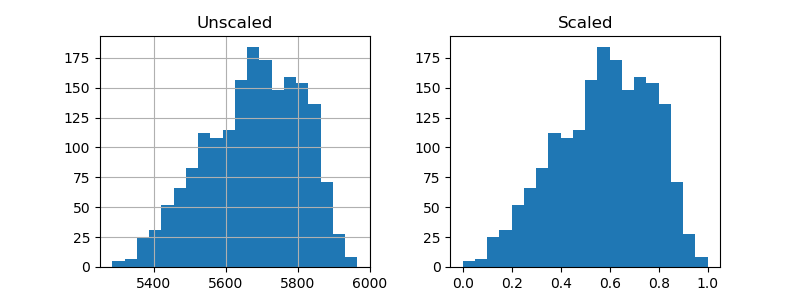

result.shape: (1806, 15, 672)
row: 1625
train.shape:
 (1625, 15, 672)
train[:10]:
 [[[0.63343041 0.63300297 0.63200403 ... 0.34545455 0.47826087 0.39285714]
  [0.53718219 0.53942074 0.54090959 ... 0.38181818 0.52173913 0.42857143]
  [0.45839263 0.46157016 0.46415081 ... 0.2        0.30434783 0.25      ]
  ...
  [0.26450426 0.27109781 0.27706808 ... 0.03636364 0.08695652 0.05357143]
  [0.15005098 0.15187859 0.15350659 ... 0.14545455 0.19565217 0.16071429]
  [0.33509081 0.33063049 0.32612921 ... 0.14545455 0.17391304 0.16071429]]

 [[0.53718219 0.53942074 0.54090959 ... 0.38181818 0.52173913 0.42857143]
  [0.45839263 0.46157016 0.46415081 ... 0.2        0.30434783 0.25      ]
  [0.46395299 0.46432673 0.46437775 ... 0.32727273 0.5        0.35714286]
  ...
  [0.15005098 0.15187859 0.15350659 ... 0.14545455 0.19565217 0.16071429]
  [0.33509081 0.33063049 0.32612921 ... 0.14545455 0.17391304 0.16071429]
  [0.43085489 0.42772209 0.42396413 ... 0.23636364 0.32608696 0.26785714]]

 [[0.45839263

In [223]:
window = 14
display(df)
X_train, y_train, X_test, y_test, data, scaler = load_data(df, window) # Reversing the order of the samples with [::-1]

print('data.shape:', data.shape)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

print('X_train[:3,:]:\n', X_train[:3,:])
print('y_train[:3]:\n', y_train[:3])
print('X_test[:3,:]:\n', X_test[:3,:])
print('y_test[:3]:\n', y_test[:3])

## Loading the model sequence structure

In [224]:
# model = build_model([3,lag,1])
# model = build_model2([n_features+1, window, 1]) # Including ERC in x_train, x_test (e.g. [25, 14, 1])
model = build_model3([n_features+1-n_locations, window, n_locations]) # Excluding ERC from x_train, x_test (e.g. [24, 14, 4])

## Executing the model & RMS/RMSE results

In [225]:
t0 = time.time()

b_s = 512
ep = 300
v_s = 0.2
erc_ex = 1 # ERC excluded? 1 if yes, 0 if no.

print('Fitting model...')
history = model.fit(
    X_train,
    y_train,
    batch_size=b_s,
    epochs=ep,
    validation_split=v_s, # Previous values: 0.1
    verbose=0)

t1 = time.time() - t0
print('Fit time {} minutes:', t1/60)

Fitting model...
Fit time {} minutes: 5.569549310207367


In [226]:
np.shape(history.history['loss'])

(300,)

Maximum validation loss: 0.10483723878860474
Minimum validation loss: 0.010603828355669975


<IPython.core.display.Javascript object>


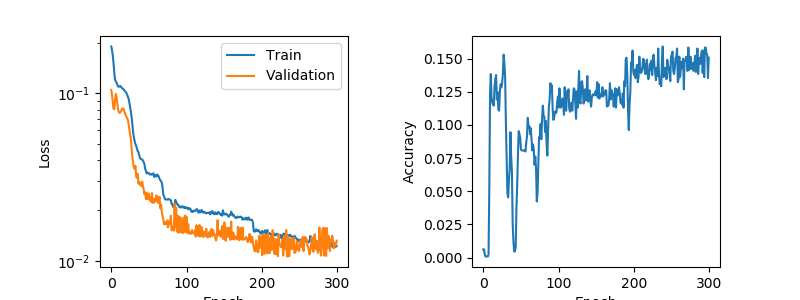

In [227]:
print('Maximum validation loss:', np.max(history.history['val_loss']))
print('Minimum validation loss:', np.min(history.history['val_loss']))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax2.plot(history.history['acc'])
ax1.set_yscale('log')
# ax2.set_yscale('log')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.subplots_adjust(wspace=0.5)
fig_str = 'FWP__RNN_metrics_w='+str(window)+'_cv=1_'+'do=2_'+'epochs='+str(ep)+'_'+'bs='+str(b_s)+'_'+'erc_ex='+str(erc_ex)+'_'+'all_NARR'
plt.savefig(fig_str, bbox_inches='tight')
plt.show()

In [228]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# predScore = model.predict(X_train, batch_size=b_s)
# print('Prediction Score:\n', predScore)

print('Average accuracy:', np.mean(history.history['acc']))

Train Score: 0.01 MSE (0.11 RMSE)
Test Score: 0.03 MSE (0.16 RMSE)
Average accuracy: 0.11782051265707767


In [229]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

/home/dp/anaconda3/envs/fwp_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/dp/anaconda3/envs/fwp_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


## Predictions vs Real results

In [230]:
display('prediction:\n', p)
display('X_test:\n', X_test)
display('y_test:\n', y_test)

inv_y_test = y_test/scaler.scale_[n_features] # Gets the last scaler coefficient corresponding to the ERC data
# Note that inv_p = scaler.inverse_transform(p) doesn't work because scaler has two coefficients, and p is only one column of data
inv_p = p/scaler.scale_[n_features]
print('Inverse transform of y_test:\n', inv_y_test)
print('Inverse transform of predicted:\n', inv_p)

# Concatenating X_test and p to use inverse_transform won't work either because X_test contains both
# NARR variables and ERC, and in a shape that doesn't match p.

u = 10
pr = p[u][0]
print(u, y_test[u], pr, (y_test[10]/pr)-1, abs(y_test[u]- pr))

'prediction:\n'

array([[0.34016976, 0.4759674 , 0.45359218, ..., 0.19984116, 0.12568963,
        0.14511351],
       [0.42375767, 0.55361736, 0.5294937 , ..., 0.27397278, 0.20070396,
        0.21918227],
       [0.45585823, 0.580241  , 0.556876  , ..., 0.30394593, 0.23049259,
        0.2487109 ],
       ...,
       [0.06046578, 0.09911971, 0.11771756, ..., 0.00680745, 0.00473692,
        0.02734304],
       [0.10841541, 0.15886933, 0.17302254, ..., 0.04801355, 0.05213857,
        0.07218987],
       [0.07570088, 0.10884587, 0.12351072, ..., 0.02445226, 0.02031905,
        0.04305412]], dtype=float32)

'X_test:\n'

array([[[0.59508553, 0.5917662 , 0.58870059, ..., 0.41127225,
         0.40002343, 0.38067314],
        [0.59282984, 0.58945471, 0.58623353, ..., 0.50797722,
         0.480517  , 0.44551504],
        [0.57060489, 0.56675013, 0.5630765 , ..., 0.64791438,
         0.61635916, 0.58666533],
        ...,
        [0.60179758, 0.60019708, 0.59882504, ..., 0.47687506,
         0.4639346 , 0.44360114],
        [0.58330644, 0.58572556, 0.58762628, ..., 0.42379202,
         0.41030075, 0.38118827],
        [0.55347816, 0.55209362, 0.5509407 , ..., 0.35792047,
         0.34288664, 0.32270237]],

       [[0.59282984, 0.58945471, 0.58623353, ..., 0.50797722,
         0.480517  , 0.44551504],
        [0.57060489, 0.56675013, 0.5630765 , ..., 0.64791438,
         0.61635916, 0.58666533],
        [0.68035057, 0.681568  , 0.68283309, ..., 0.51465066,
         0.49742944, 0.47543952],
        ...,
        [0.58330644, 0.58572556, 0.58762628, ..., 0.42379202,
         0.41030075, 0.38118827],
        [0.5

'y_test:\n'

array([[0.52777778, 0.58333333, 0.62820513, ..., 0.14545455, 0.10869565,
        0.17857143],
       [0.55555556, 0.61111111, 0.65384615, ..., 0.05454545, 0.        ,
        0.21428571],
       [0.56944444, 0.61111111, 0.66666667, ..., 0.09090909, 0.02173913,
        0.10714286],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Inverse transform of y_test:
 [[29.55555556 32.66666667 35.17948718 ...  8.14545455  6.08695652
  10.        ]
 [31.11111111 34.22222222 36.61538462 ...  3.05454545  0.
  12.        ]
 [31.88888889 34.22222222 37.33333333 ...  5.09090909  1.2173913
   6.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Inverse transform of predicted:
 [[19.049505   26.654173   25.401161   ... 11.191104    7.0386186
   8.126356  ]
 [23.730429   31.002571   29.651646   ... 15.342475   11.239422
  12.274206  ]
 [25.528059   32.493496   31.185055   ... 17.020971   12.907584
  13.92781   ]
 ...
 [ 3.3860834   5.5507035   6.592183   ...  0.3812173   0.26526776
   1.5312101 ]
 [ 6.071263    8.896682    9.689261   ...  2.6887589   2.91976
   4.0426326 ]
 [ 4.239249    6.0953684   6.9165998  ...  1.3693262   1.137867
   2.4110305

In [231]:
print(X_test.shape)
print(y_test.shape)
print(p.shape)
print(X_test)

(181, 14, 576)
(181, 96)
(181, 96)
[[[0.59508553 0.5917662  0.58870059 ... 0.41127225 0.40002343 0.38067314]
  [0.59282984 0.58945471 0.58623353 ... 0.50797722 0.480517   0.44551504]
  [0.57060489 0.56675013 0.5630765  ... 0.64791438 0.61635916 0.58666533]
  ...
  [0.60179758 0.60019708 0.59882504 ... 0.47687506 0.4639346  0.44360114]
  [0.58330644 0.58572556 0.58762628 ... 0.42379202 0.41030075 0.38118827]
  [0.55347816 0.55209362 0.5509407  ... 0.35792047 0.34288664 0.32270237]]

 [[0.59282984 0.58945471 0.58623353 ... 0.50797722 0.480517   0.44551504]
  [0.57060489 0.56675013 0.5630765  ... 0.64791438 0.61635916 0.58666533]
  [0.68035057 0.681568   0.68283309 ... 0.51465066 0.49742944 0.47543952]
  ...
  [0.58330644 0.58572556 0.58762628 ... 0.42379202 0.41030075 0.38118827]
  [0.55347816 0.55209362 0.5509407  ... 0.35792047 0.34288664 0.32270237]
  [0.72760083 0.72488731 0.72203697 ... 0.50050594 0.48211836 0.45828651]]

 [[0.57060489 0.56675013 0.5630765  ... 0.64791438 0.61635916

<IPython.core.display.Javascript object>


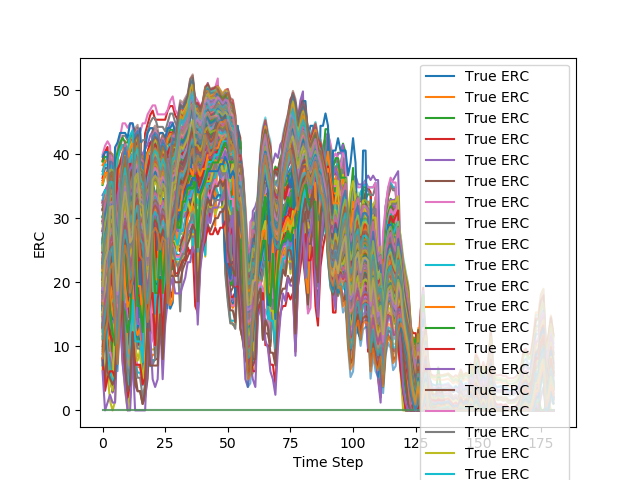

In [232]:
plt.figure()
plt.plot(inv_y_test, label='True ERC')
plt.plot(inv_p, label='Predicted ERC', alpha=0.6)
plt.legend(loc='upper right')
plt.xlabel('Time Step')
plt.ylabel('ERC')
fig_str = 'FWP__RNN_results_w='+str(window)+'_cv=1_'+'do=2_'+'epochs='+str(ep)+'_'+'bs='+str(b_s)+'_'+'erc_ex='+str(erc_ex)+'_'+'all_NARR'
plt.savefig(fig_str, bbox_inches='tight')
plt.show()

In [233]:
# Converting inv_y_test and inv_p to tidy formatted dataframe, merging, then plotting with seaborn
df_inv_y_test = pd.DataFrame(inv_y_test, columns=range(0,n_locations))
df_inv_y_test['Day'] = range(len(inv_y_test))
df_inv_y_test_tidy = df_inv_y_test.melt(id_vars=['Day'], value_vars=range(0,n_locations), var_name='Loc', value_name='Test ERC')
df_inv_y_test_tidy.set_index(['Day','Loc'], inplace=True)

df_inv_p = pd.DataFrame(inv_p, columns=range(0,n_locations))
df_inv_p['Day'] = range(len(inv_p))
df_inv_p_tidy = df_inv_p.melt(id_vars=['Day'], value_vars=range(0,n_locations), var_name='Loc', value_name='Pred ERC')
df_inv_p_tidy.set_index(['Day','Loc'], inplace=True)

# Concatenating
df_inv_tidy = pd.concat((df_inv_y_test_tidy, df_inv_p_tidy), axis=1, join='inner', sort=False)
display('df_inv_tidy before melting:', df_inv_tidy)

# Melting
df_inv_tidy.reset_index(inplace=True)
df_inv_tidy = df_inv_tidy.melt(id_vars=['Day','Loc'], value_vars=['Test ERC','Pred ERC'], var_name='ERC Type', value_name='ERC')
display('df_inv_tidy melted:', df_inv_tidy)

'df_inv_tidy before melting:'

Test ERC   Pred ERC
Day Loc                      
0   0    29.555556  19.049505
1   0    31.111111  23.730429
2   0    31.888889  25.528059
3   0    21.000000  33.537189
4   0    21.000000  33.979923
...            ...        ...
176 95    0.000000   7.096619
177 95    0.000000   0.600140
178 95    0.000000   1.531210
179 95    0.000000   4.042633
180 95    0.000000   2.411031

[17376 rows x 2 columns]

'df_inv_tidy melted:'

Day  Loc  ERC Type        ERC
0        0    0  Test ERC  29.555556
1        1    0  Test ERC  31.111111
2        2    0  Test ERC  31.888889
3        3    0  Test ERC  21.000000
4        4    0  Test ERC  21.000000
...    ...  ...       ...        ...
34747  176   95  Pred ERC   7.096619
34748  177   95  Pred ERC   0.600140
34749  178   95  Pred ERC   1.531210
34750  179   95  Pred ERC   4.042633
34751  180   95  Pred ERC   2.411031

[34752 rows x 4 columns]

<IPython.core.display.Javascript object>


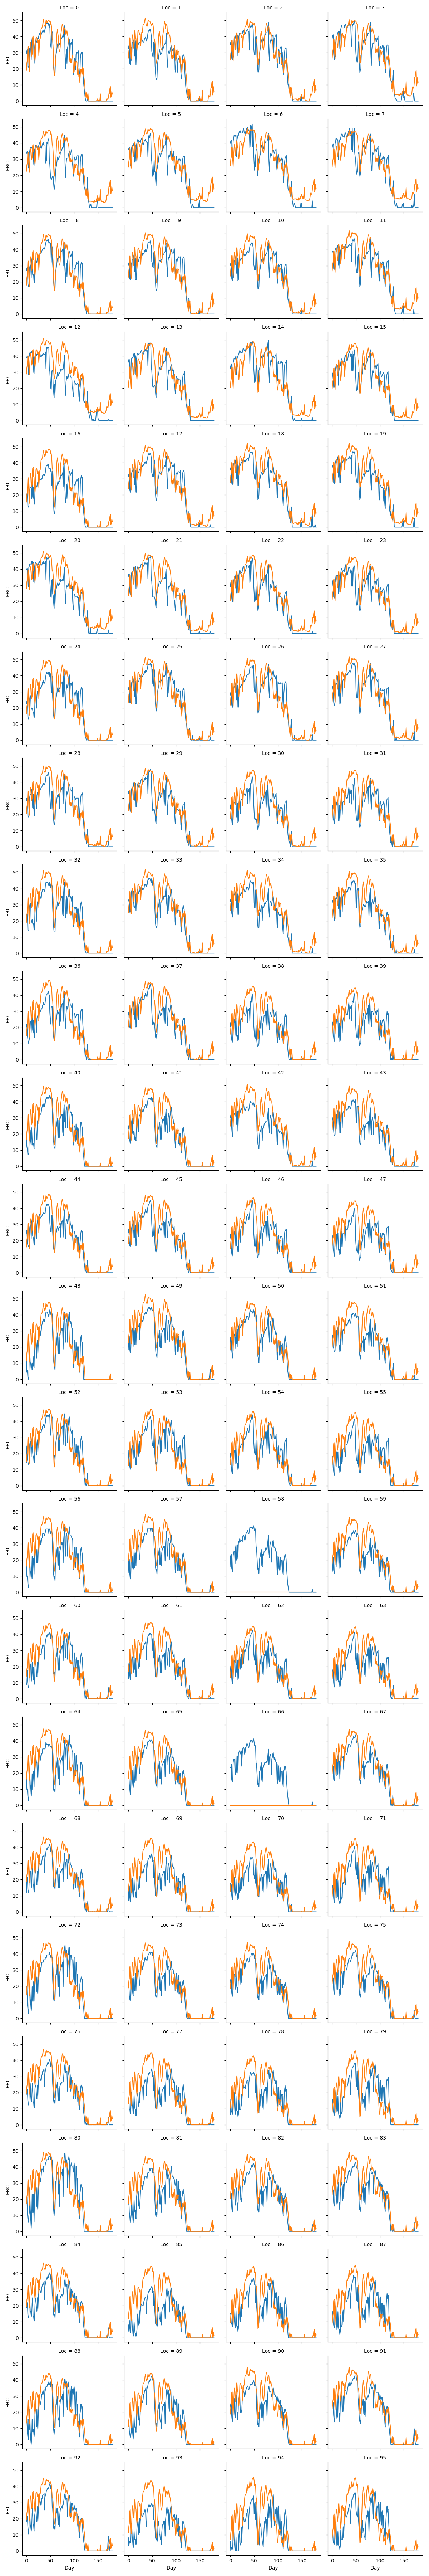

In [234]:
g = sns.FacetGrid(df_inv_tidy, col='Loc', hue='ERC Type', col_wrap=4, height=3) # palette='tab20c'
g.map(plt.plot, 'Day', 'ERC')

# # Adjust the tick positions and labels
# g.set(xticks=np.arange(181), yticks=[0, 70], xlim=(-0.5, 182), ylim=(-0.5, 71))

# Adjust the arrangement of the plots
g.fig.tight_layout(w_pad=1)

# Save figure
fig_str = 'FWP__RNN_results_split_w='+str(window)+'_cv=1_'+'do=2_'+'epochs='+str(ep)+'_'+'bs='+str(b_s)+'_'+'erc_ex='+str(erc_ex)+'_'+'all_NARR'
plt.savefig(fig_str, bbox_inches='tight')